In [13]:
"""Plot frequency comb from NLTL simulation (13-section, x³ only) using PyQSPICE."""
import numpy as np
import matplotlib.pyplot as plt
from PyQSPICE import clsQSPICE as pqs
from pathlib import Path
import shutil

In [14]:
# Setup PyQSPICE
work_dir = Path(r"c:\Users\madan\Documents\QSPICE\QSPICE_DSP\duffing")
qsch_file = work_dir / "duffing.qsch"


In [15]:
run = pqs(str(work_dir / "duffing"))


In [16]:
# Load the qraw data — PyQSPICE needs the qraw to exist already
# It uses QUX.exe -Export to read it

probes = [f"V(x{i})" for i in range(1, 14)]
df = run.LoadQRAW(probes)

print(f"Loaded DataFrame: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(df.head())

Loaded DataFrame: (5000, 15)
Columns: ['Time', 'V(x1)', 'V(x2)', 'V(x3)', 'V(x4)', 'V(x5)', 'V(x6)', 'V(x7)', 'V(x8)', 'V(x9)', 'V(x10)', 'V(x11)', 'V(x12)', 'V(x13)', 'Step']
       Time         V(x1)         V(x2)         V(x3)         V(x4)  \
0  0.000000  2.265563e-07  2.076756e-07  1.887961e-07  1.699166e-07   
1  0.002000  1.656775e+00  8.196698e-01  8.183548e-01  8.170402e-01   
2  0.004001  3.268869e+00  1.605575e+00  1.604290e+00  1.603013e+00   
3  0.006001  4.814287e+00  2.349847e+00  2.348614e+00  2.347391e+00   
4  0.008002  6.275389e+00  3.048145e+00  3.046984e+00  3.045831e+00   

          V(x5)         V(x6)         V(x7)         V(x8)         V(x9)  \
0  1.510371e-07  1.321576e-07  1.132781e-07  9.439864e-08  7.551914e-08   
1  8.157381e-01  8.144251e-01  8.131335e-01  8.118302e-01  8.105397e-01   
2  1.601742e+00  1.600476e+00  1.599220e+00  1.597965e+00  1.596724e+00   
3  2.346174e+00  2.344966e+00  2.343766e+00  2.342574e+00  2.341391e+00   
4  3.044687e+00  3.043

In [17]:
# Steady-state slice (last 50%) — use actual Time column, not integer index
t_all = df["Time"].values
t_start = t_all[len(t_all) // 2]
mask = df["Time"] >= t_start
df_ss = df[mask]

t_ss = df_ss["Time"].values
v_ss = df_ss["V(x13)"].values

dt = np.mean(np.diff(t_ss))
fs = 1 / dt

print(f"Steady-state from {t_start:.4f} s to {t_all[-1]:.4f} s")
print(f"dt = {dt*1e6:.3f} µs  (fs = {fs:.1f} Hz)")
print(f"Points in steady state: {len(v_ss)}")
print(f"Min dt: {np.diff(t_ss).min()*1e6:.3f} µs  Max dt: {np.diff(t_ss).max()*1e6:.3f} µs")

Steady-state from 5.0010 s to 10.0000 s
dt = 2000.400 µs  (fs = 499.9 Hz)
Points in steady state: 2500
Min dt: 2000.400 µs  Max dt: 2000.400 µs


In [18]:
window = np.hanning(len(v_ss))
fft_vals = np.fft.rfft(v_ss * window)
freqs = np.fft.rfftfreq(len(v_ss), d=dt)
magnitude_dB = 20 * np.log10(np.abs(fft_vals) / len(v_ss) + 1e-12)

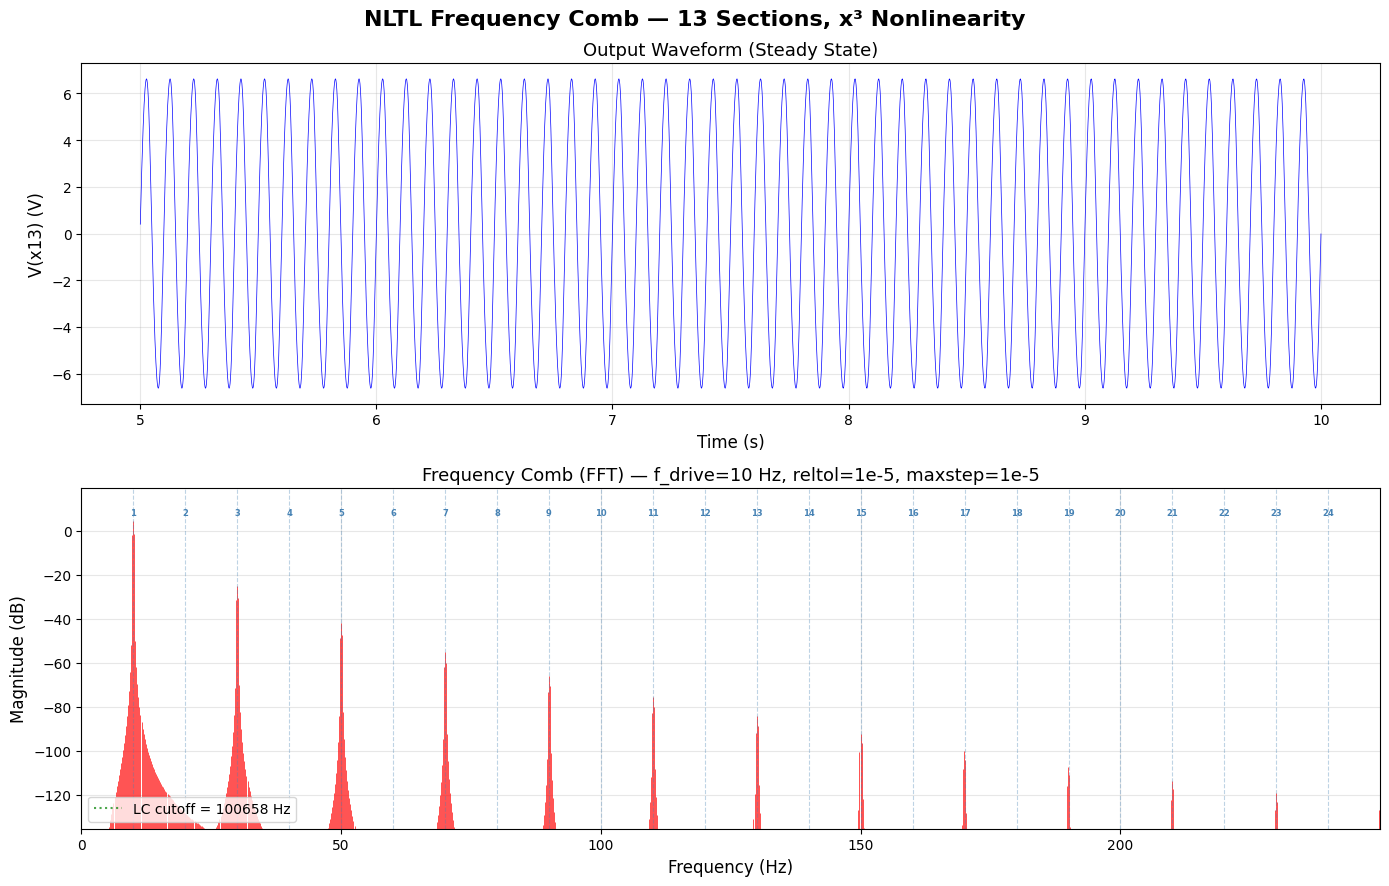

LC cutoff: 100658.4 Hz
Nyquist: 250.0 Hz
Comb teeth shown: 24


In [19]:
# --- Plot ---
fig, axes = plt.subplots(2, 1, figsize=(14, 9))
fig.suptitle('NLTL Frequency Comb — 13 Sections, x³ Nonlinearity', fontsize=16, fontweight='bold')

# Time domain
ax1 = axes[0]
ax1.plot(t_ss, v_ss, 'b-', linewidth=0.5)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('V(x13) (V)', fontsize=12)
ax1.set_title('Output Waveform (Steady State)', fontsize=13)
ax1.grid(True, alpha=0.3)

# FFT
ax2 = axes[1]
L = 100e-6
C = 100e-9
f_cutoff = 1 / (np.pi * np.sqrt(L * C))
f_drive = 10  # Hz
f_max = min(f_cutoff * 1.5, fs / 2)  # don't exceed Nyquist

freq_mask = (freqs >= 1) & (freqs <= f_max)
f_plot = freqs[freq_mask]
m_plot = magnitude_dB[freq_mask]

peak_dB = np.max(m_plot)
noise_floor = peak_dB - 140

# Draw spectrum as vertical lines from noise floor
ax2.vlines(f_plot, noise_floor, m_plot, colors='red', linewidth=0.6, alpha=0.8)

# Mark expected comb teeth
n_teeth = int(f_max / f_drive)
for n in range(1, n_teeth + 1):
    f_line = n * f_drive
    ax2.axvline(x=f_line, color='steelblue', linewidth=0.8, linestyle='--', alpha=0.35)
    if n <= 40 or n % 5 == 0:
        ax2.text(f_line, peak_dB + 2, f'{n}', ha='center', va='bottom',
                 fontsize=6, color='steelblue', fontweight='bold')

ax2.axvline(x=f_cutoff, color='green', linewidth=1.5, linestyle=':', alpha=0.7,
            label=f'LC cutoff = {f_cutoff:.0f} Hz')
ax2.legend(fontsize=10)

ax2.set_xlabel('Frequency (Hz)', fontsize=12)
ax2.set_ylabel('Magnitude (dB)', fontsize=12)
ax2.set_title(f'Frequency Comb (FFT) — f_drive={f_drive} Hz, reltol=1e-5, maxstep=1e-5', fontsize=13)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(noise_floor, peak_dB + 15)
ax2.set_xlim(0, f_max)

plt.tight_layout()
plt.show()

print(f"LC cutoff: {f_cutoff:.1f} Hz")
print(f"Nyquist: {fs/2:.1f} Hz")
print(f"Comb teeth shown: {n_teeth}")